<a href="https://colab.research.google.com/github/Nillzzz/Python4DS/blob/master/Mode%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import re, json
import matplotlib.pyplot as plt

In [51]:
with open('/content/export_35993_batch_hr_Spain_offset_0_1596470000.json', 'r') as f:
    dataset = '[' + re.sub(r'\}\s\{', '},{', f.read()) + ']'
    dataset = json.loads(dataset.lower())

In [52]:
dataset[0]

{'about': 'excellent experience in sales and business solution, dealing with partners and end customers.\n 5 years experience in multinational environments.\n team player, able to manage multitask roles, used to work with targets, result and customer oriented, high multilingual knowledge, excellent communication skills.\n\n specialties:\n - sales, business development, negotiation, account management.\n - it services, web analytic, web marketing, sem, seo.\n - languages: fluent in italian, english and spanish.',
 'company': {'address_hq': '2201 lakeside blvd. richardson, texas 75082 united states',
  'company_intern_id': 'realpage',
  'company_name': 'realpage, inc.',
  'founded_date': '1998',
  'industry': 'computer software',
  'location': {'city_name': 'richardson',
   'country_name': 'united states',
   'state_name': 'texas',
   'zip_code': '75082'},
  'scraping_services_id': 8613036,
  'size_max': 10000,
  'size_min': 5001,
  'summary': 'realpage, inc. is a leading provider of com

In [53]:
objs = list()

for user in dataset:
    try:
        objs.append({
            'full_name': ' '.join([user['first_name'], user['last_name']]),
            'industry': user['v_extension']['industry_from_job'],
            'functions': user['v_extension']['job_functions'].split(',') if user['v_extension']['job_functions'] else [],
            'skills': user['skills'] if 'skills' in user else [],
            'location': user['location']['city_name'] if 'city_name' in user['location'] else 'undefined'
        })
    except:
        continue

In [54]:
import pandas as pd

dataset = pd.DataFrame(objs)
dataset.head(8)

,full_name,industry,functions,skills,location
0,alessandro alecci,financial services,"[finance, operations, sales]","[b2b, b2b marketing, business development, bus...",barcelona
1,liborio oficialdegui,False,[operations],[],pamplona
2,aleen hasck,False,[operations],"[budgets, c, c++, customer service, editing, e...",undefined
3,alejandro moreno,events services,[administrative],[],undefined
4,mila aleksic,False,"[entrepreneurship, operations]","[customer service, english, european union, ge...",undefined
5,jelena aleksic,None,[],[],undefined
6,natalia cobo,information technology & services,"[information technology, operations]",[],barcelona
7,federico ynzenga,False,"[entrepreneurship, operations]","[business strategy, change management, continu...",undefined


# Language Extraction

In [11]:
def Language_detection(dataset):
    l=[]
    for i in range(len(dataset)):
        lang=[]
        for s in dataset.skills.iloc[i]:
            if s=='english':
                lang.append('english')
            if s=='spanish':
                lang.append('spanish')
            if s=='italian':
                lang.append('italian')
                break
        l.append(lang)
    return l

In [12]:
len(Language_detection(dataset))

199

In [ ]:
Language_detection(dataset)

In [14]:
dataset['language'] = Language_detection(dataset)
dataset

,full_name,industry,functions,skills,location,language
0,alessandro alecci,financial services,"[finance, operations, sales]","[b2b, b2b marketing, business development, bus...",barcelona,[]
1,liborio oficialdegui,False,[operations],[],pamplona,[]
2,aleen hasck,False,[operations],"[budgets, c, c++, customer service, editing, e...",undefined,[english]
3,alejandro moreno,events services,[administrative],[],undefined,[]
4,mila aleksic,False,"[entrepreneurship, operations]","[customer service, english, european union, ge...",undefined,[english]
...,...,...,...,...,...,...
194,fatima asali,False,[apprentice],[],undefined,[]
195,ignacio sáez,information technology & services,"[information technology, operations]","[.net, android development, angularjs, apache,...",undefined,[english]
196,alfredo asaoka,False,[operations],[],undefined,[]
197,roberto lucerga,None,[],"[biodiesel production, biofuels, business deve...",alcobendas,[]


# Mode 1

Filter based on Location and English Language

**Test Case:**

* Location = "Madrid"
*Language = "English"

## 1. Filtering Data

In [15]:
def Filtering_data (language , location ):
    data = dataset[dataset['language'] == [language]]
    data= data [data['location']==location]
    return data

In [16]:
def Filtering_data (language , location ):
    l=[]
    for i in range(len(dataset)):
        for j in range(len(dataset.language.iloc[i])):
            if dataset.language.iloc[i][j] == language:
                l.append(dataset.iloc[i])
                break
    data = pd.DataFrame(data=l , columns=['full_name', 'industry', 'functions', 'skills', 'location', 'language'])
    data= data [data['location']==location] 
    return data

In [17]:
data = Filtering_data(language='english',location='madrid')
data

,full_name,industry,functions,skills,location,language
43,ander gómez,False,[operations],"[business operations, business strategy, chang...",madrid,"[english, spanish]"
67,alexander vega,None,[],"[agribusiness, agriculture, agronomy, english,...",madrid,"[english, spanish]"
170,daniel artalejo,computer software,[information technology],"[android, angularjs, c (programación), c++, cs...",madrid,[english]


## 2. Building the graph

In [18]:
def Building_Digraph (data):
    graph = nx.DiGraph()
    for row, index in data.iterrows():
        if index['industry'] is not False:
            graph.add_edge(u_of_edge=index['full_name'],v_of_edge=index['industry'])
        if index['location'] != "Undefined":
            graph.add_edge(u_of_edge=index['full_name'],v_of_edge=index['location'])
        for skill in index['skills']:
            graph.add_edge(u_of_edge=skill, v_of_edge=index['full_name'])
        for function in index['functions']:
            graph.add_edge(u_of_edge=index['full_name'], v_of_edge=function)
    return graph
                

In [19]:
DiG = Building_Digraph(data)

## 3. Digraph Visualization

In [20]:
def DiGraph_visualization (DiG):
    plt.figure(figsize=(20,10))
    nx.draw(DiG, with_labels=True, node_size=50, node_color="skyblue", node_shape="s", alpha=0.8, linewidths=4)
    plt.show()

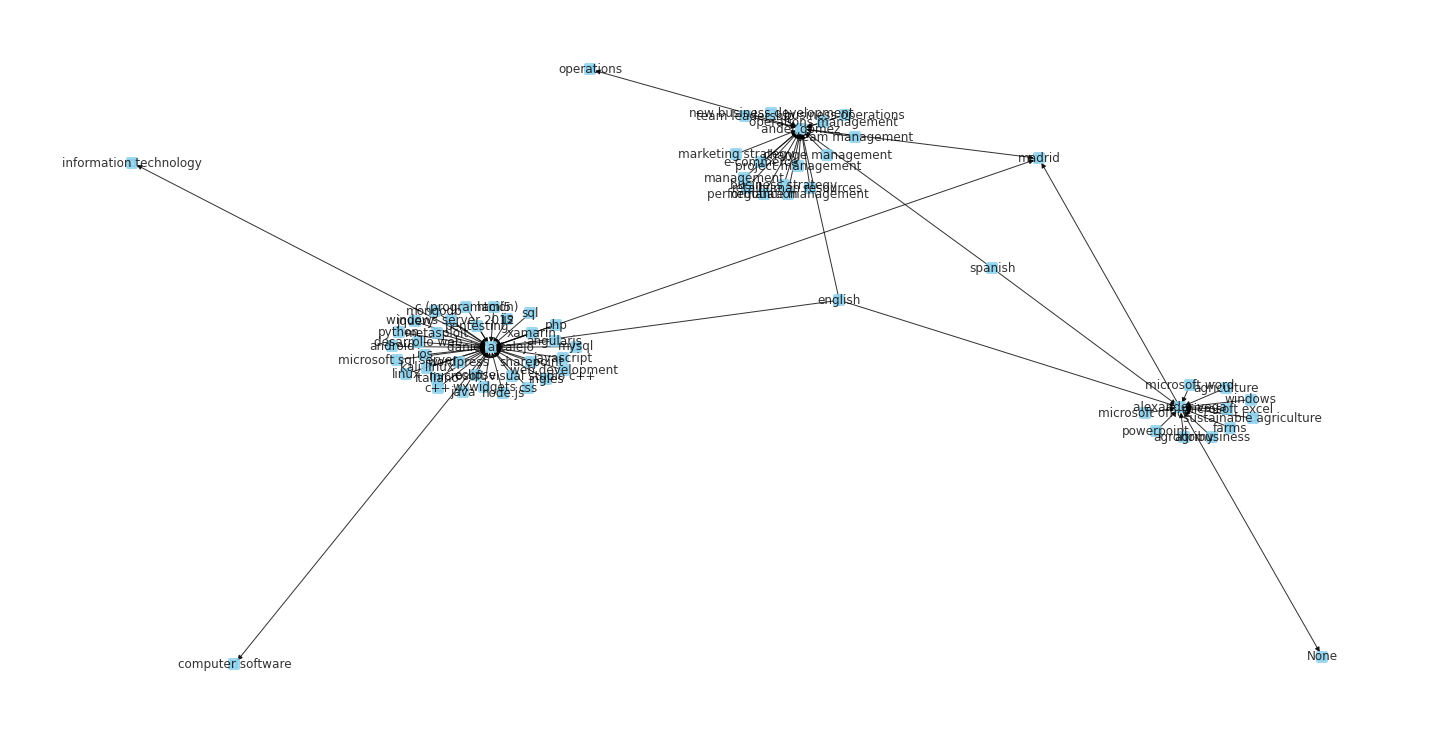

In [21]:
DiGraph_visualization(DiG)

## 4. Graph Feature Analysis

In [32]:
def Graph_measurements(DiG):
    dict1 =(nx.in_degree_centrality(DiG))
    result= pd.DataFrame(data= dict1, columns=['node','indegree_centrality','outdegree_centrality','in_degree','out_degree','degree','closeness_centrality','betweenness_centrality','skills'])
    node=[]
    indegcent=[]
    for k,v in dict1.items():
        node.append(k)
        indegcent.append(v)
    
    result['node'] = node
    result['indegree_centrality'] = indegcent
    result = result.set_index('node')
    
    dict1 =(nx.out_degree_centrality(DiG))
    for k,v in dict1.items():
        result['outdegree_centrality'].loc[k]=(v)
    
    dict1 = dict(DiG.in_degree(list(DiG.nodes)))
    for k,v in dict1.items():
        result['in_degree'].loc[k]=(v)
    
    dict1 = dict(DiG.out_degree(list(DiG.nodes)))
    for k,v in dict1.items():
        result['out_degree'].loc[k]=(v)

    dict1 = dict(DiG.degree(list(DiG.nodes)))
    for k,v in dict1.items():
        result['degree'].loc[k]=(v)

    dict1 = nx.closeness_centrality(DiG)
    for k,v in dict1.items():
        result['closeness_centrality'].loc[k]=(v)

    dict1 = nx.betweenness_centrality(DiG)
    for k,v in dict1.items():
        result['betweenness_centrality'].loc[k]=(v)
    return result


In [64]:
output = Graph_measurements(DiG)
output.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,indegree_centrality,outdegree_centrality,in_degree,out_degree,degree,closeness_centrality,betweenness_centrality,skills
node,,,,,,,,
ander gómez,0.253731,0.0298507,17,2,19,0.253731,0.007425,NaN
madrid,0.044776,0,3,0,3,0.481616,0,NaN
business operations,0.000000,0.0149254,0,1,1,0,0,NaN
business strategy,0.000000,0.0149254,0,1,1,0,0,NaN
change management,0.000000,0.0149254,0,1,1,0,0,NaN


## 5. Merge Dataframes

In [102]:
def Merge_results (data, output):
    output= output.reset_index()
    l=[]
    m1,m2, m3, m4, m5, m6 , m7=[],[],[],[],[],[],[]
    for node in User_filter_City (DiG, city = 'madrid'):
        for i in range(len(data)):
            if data.full_name.iloc[i] == node:
                l.append(data.iloc[i])
        for j in range(len(output)):
            if output.node.iloc[j] == node:
                m1.append(output.indegree_centrality.iloc[j])
                m2.append(output.outdegree_centrality.iloc[j])
                m3.append(output.in_degree.iloc[j])
                m4.append(output.out_degree.iloc[j])
                m5.append(output.degree.iloc[j])
                m6.append(output.closeness_centrality.iloc[j])
                m7.append(output.betweenness_centrality.iloc[j])
    res = pd.DataFrame(data=l , columns = ['full_name', 'industry', 'functions', 'skills', 'location', 'indegree_centrality', 'outdegree_centrality', 'in_degree', 'out_degree', 'degree', 'closeness_centrality','betweenness_centrality'])
    res['indegree_centrality']=m1
    res['outdegree_centrality']=m2
    res['in_degree']=m3
    res['out_degree']=m4
    res['degree']=m5
    res['closeness_centrality']=m6
    res['betweenness_centrality']=m7
    return res

In [104]:
querry_result = Merge_results(data, output)
querry_result

,full_name,industry,functions,skills,location,indegree_centrality,outdegree_centrality,in_degree,out_degree,degree,closeness_centrality,betweenness_centrality
43,ander gómez,False,[operations],"[business operations, business strategy, chang...",madrid,0.253731,0.029851,17,2,19,0.253731,0.007425
67,alexander vega,None,[],"[agribusiness, agriculture, agronomy, english,...",madrid,0.179104,0.029851,12,2,14,0.179104,0.005164
170,daniel artalejo,computer software,[information technology],"[android, angularjs, c (programación), c++, cs...",madrid,0.507463,0.044776,34,3,37,0.507463,0.022916


In [65]:
output= output.reset_index()
output

,node,indegree_centrality,outdegree_centrality,in_degree,out_degree,degree,closeness_centrality,betweenness_centrality,skills
0,ander gómez,0.253731,0.0298507,17,2,19,0.253731,0.007425,NaN
1,madrid,0.044776,0,3,0,3,0.481616,0,NaN
2,business operations,0.000000,0.0149254,0,1,1,0,0,NaN
3,business strategy,0.000000,0.0149254,0,1,1,0,0,NaN
4,change management,0.000000,0.0149254,0,1,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...
63,jquery,0.000000,0.0149254,0,1,1,0,0,NaN
64,pentesting,0.000000,0.0149254,0,1,1,0,0,NaN
65,wxwidgets,0.000000,0.0149254,0,1,1,0,0,NaN
66,xamarin,0.000000,0.0149254,0,1,1,0,0,NaN


In [99]:
l=[]
m1,m2, m3, m4, m5, m6 , m7=[],[],[],[],[],[],[]
for node in User_filter_City (DiG, city = 'madrid'):
    for i in range(len(dataset)):
        if dataset.full_name.iloc[i] == node:
            l.append(dataset.iloc[i])
    for j in range(len(output)):
        if output.node.iloc[j] == node:
            m1.append(output.indegree_centrality.iloc[j])
            m2.append(output.outdegree_centrality.iloc[j])
            m3.append(output.in_degree.iloc[j])
            m4.append(output.out_degree.iloc[j])
            m5.append(output.degree.iloc[j])
            m6.append(output.closeness_centrality.iloc[j])
            m7.append(output.betweenness_centrality.iloc[j])


In [101]:
res = pd.DataFrame(data=l , columns = ['full_name', 'industry', 'functions', 'skills', 'location', 'indegree_centrality', 'outdegree_centrality', 'in_degree', 'out_degree', 'degree', 'closeness_centrality','betweenness_centrality'])
res['indegree_centrality']=m1
res['outdegree_centrality']=m2
res['in_degree']=m3
res['out_degree']=m4
res['degree']=m5
res['closeness_centrality']=m6
res['betweenness_centrality']=m7
res.head()

,full_name,industry,functions,skills,location,indegree_centrality,outdegree_centrality,in_degree,out_degree,degree,closeness_centrality,betweenness_centrality
43,ander gómez,False,[operations],"[business operations, business strategy, chang...",madrid,0.253731,0.029851,17,2,19,0.253731,0.007425
67,alexander vega,None,[],"[agribusiness, agriculture, agronomy, english,...",madrid,0.179104,0.029851,12,2,14,0.179104,0.005164
170,daniel artalejo,computer software,[information technology],"[android, angularjs, c (programación), c++, cs...",madrid,0.507463,0.044776,34,3,37,0.507463,0.022916


## Neighbours

In [37]:
# Filtering People based on the city:
def User_filter_City (DiG, city):
    return list(nx.all_neighbors(DiG, city))

In [38]:
User_filter_City (DiG, city = 'madrid')

['ander gómez', 'alexander vega', 'daniel artalejo']

## Suggestion

In [ ]:
def Suggestions (DiG , city):
    users = dict()
    l=list(nx.all_neighbors(DiG, city))
    for ppl in l:
        users['Full_name']= ppl
        skills = data[data['full_name']== ppl]['skill']
    return users